In [1]:
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


# Divide train and test set

In [0]:
import json
import pandas as pd
import numpy as np
import os, os.path
import time
import csv

N_FACE = 70
N_POSE = 25
N_HAND = 21
FOLDER = '/content/drive/My Drive/636/data/json/'
CSV_FOLDER = '/content/drive/My Drive/636/dataset/'

In [3]:
ls '/content/drive/My Drive/636/dataset/'

dataset.csv            dataset_re.csv    part/
dataset_face_hand.csv  drop_data.csv     pos_data_all_new.csv
dataset_pose_only.csv  neg_data_all.csv


In [0]:
dataset = pd.read_csv(CSV_FOLDER + 'dataset_face_hand.csv')

In [5]:
vid = dataset.vid.unique()

from sklearn.model_selection import train_test_split
X_train_vid, X_test_vid= train_test_split(vid, test_size=0.15, random_state=1)
print(X_train_vid.shape, X_test_vid.shape)

X_test_data = dataset.loc[dataset['vid'].isin(X_test_vid)]
X_test_data = X_test_data.reset_index()
X_test_data.drop(X_test_data.columns[[0]], axis=1, inplace=True)

X_train_data = dataset.loc[dataset['vid'].isin(X_train_vid)]
X_train_data = X_train_data.reset_index()
X_train_data.drop(X_train_data.columns[[0]], axis=1, inplace=True)

print(X_test_data.shape[0] / dataset.shape[0])
print(X_test_data.index[X_test_data['label'] == 1].shape[0] / X_test_data.index[X_test_data['label'] == 0].shape[0])

(171,) (31,)
0.14348855564325178
1.0574920778632866


In [0]:
# normalize
def normalize(df):
  x_df = df.iloc[:,3:].copy()
  num_df = x_df.sub(x_df[x_df > 0].min(axis=1) - 0.0001, axis=0)
  den_df = x_df.max(axis=1) - (x_df[x_df > 0.1].min(axis=1) - 0.0001)
  x_df = num_df.div(den_df, axis=0)
  x_df[x_df < 0] = 0
  df.iloc[:,3:] = x_df

normalize(X_train_data)
normalize(X_test_data)

In [18]:
print(X_train_data.shape, X_test_data.shape)

(27130, 227) (4545, 227)


In [0]:
# X_train_data.vid.unique()
# get number of features
# N_FEATURES = (N_POSE + N_HAND * 2) * 2
N_FEATURES = (N_FACE + N_HAND * 2) * 2

In [9]:
N_FEATURES

224

# Slice every TIME_STEP frame as a segment and shuffle

In [0]:
# slice every TIME_STEP frame as a segment until from 1st frame to last, if null, make up with 0
def get_slices(df, index_arr, TIME_STEP):
  slices = []
  for i in index_arr:
    if i + 1 < TIME_STEP:
      # slice_ = df.values[df.index[0 : i + 1]]
      # fillzero = np.zeros((TIME_STEP - i - 1, N_FEATURES))
      # slice_ = np.concatenate((slice_, fillzero), axis=0)
      # slices.append(slice_)
      continue
    else:
      slices.append(df.values[df.index[i + 1 - TIME_STEP : i + 1]])

  slices_arr = np.asarray(slices, dtype= np.float32)
  return slices_arr

In [0]:
def create_segments(df, TIME_STEP):
  # get video id
  vids = df.vid.unique()
  segments = []
  # get segment of each video id
  for i in vids:
    # slice every 10 frame as a segment and use the first label as label of segment
    # get all index of an id
    index_arr = df.index[df['vid'] == i]
    # drop the id and label
    df_s = df[df.columns[3:]]

    if i == vids[0]:
      segments = get_slices(df_s, index_arr, TIME_STEP)
    else:
      # get slices of each person
      segment = get_slices(df_s, index_arr, TIME_STEP)
      # print(i, segment.shape)
      segments = np.concatenate((segments, segment), axis=0)

  return segments

In [0]:
TIME_STEP = 15
y_train = X_train_data['label'].to_numpy()[TIME_STEP - 1:]
y_test = X_test_data['label'].to_numpy()[TIME_STEP - 1:]
X_train = create_segments(X_train_data, TIME_STEP)
X_test = create_segments(X_test_data, TIME_STEP)

In [0]:
# shuffle data
idx_train = np.random.permutation(y_train.shape[0])
X_train, y_train = X_train[idx_train], y_train[idx_train]

In [23]:
X_train.shape

(27116, 15, 224)

In [0]:
# draw plot
import matplotlib.pyplot as plt
def draw(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(acc) + 1)
  plt.plot(epochs, acc, 'b', label='Training acc', color='red')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')

  plt.title('Training and validation accuracy')
  plt.legend()
  plt.figure()
  plt.plot(epochs, loss, 'b', label='Training loss', color='red')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()

# Build model

In [0]:
%tensorflow_version 1.x
from keras.layers.embeddings import Embedding
from keras.optimizers import SGD, RMSprop
from keras.models import Sequential
from keras.layers import Dense, LSTM, CuDNNLSTM, Activation, Dropout, Flatten, Bidirectional, Conv1D, MaxPooling1D, GlobalAveragePooling1D, BatchNormalization, Conv2D, MaxPooling2D, AveragePooling1D, GlobalMaxPooling1D
from keras.callbacks import History, EarlyStopping, ModelCheckpoint,LearningRateScheduler

In [0]:
# hyperparameter
BATCH_SIZE = 64
EPOCH = 100
DROPOUT = 0.5
INPUT_DIM = N_FEATURES
# callbacks
mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
early_stop = EarlyStopping(monitor='val_loss', patience=3, 
                           verbose=2, mode='min')
callbacks_list = [early_stop, mcp_save]
opt = SGD(lr=1e-2, momentum=0.9, decay=1e-2/EPOCH)
rmsprop = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
# callbacks_list = [early_stop]
model_path = './drive/My Drive/636/model/'

## Model 1 3 LSTM 0.8079

In [0]:
def create_model_1():
  model = Sequential()
  model.add(Dense(units = 64, input_shape=(TIME_STEP, INPUT_DIM), activation='relu'))
  model.add(CuDNNLSTM(units = 64, input_shape=(TIME_STEP, INPUT_DIM), return_sequences = True))
  model.add(Dropout(DROPOUT))
  model.add(CuDNNLSTM(units = 32, input_shape=(TIME_STEP, INPUT_DIM), return_sequences = True))
  model.add(Dropout(DROPOUT))
  model.add(CuDNNLSTM(units = 32))
  model.add(Dense(1, activation='sigmoid'))
  model.summary()
  model.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['acc'])
  return model

In [30]:
# create model
model_1 = create_model_1()
history = model_1.fit(X_train, y_train, epochs=EPOCH, batch_size=30, 
                    validation_split=0.2, verbose=2, callbacks=callbacks_list)
score = model_1.evaluate(X_test, y_test, verbose=2)
print("test loss: ", score[0], "test acc: ", score[1])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 15, 64)            14400     
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 15, 64)            33280     
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 64)            0         
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 15, 32)            12544     
_________________________________________________________________
dropout_2 (Dropout)          (None, 15, 32)            0         
_________________________________________________________________
cu_dnnlstm_3 (CuDNNLSTM)     (None, 32)                8448      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

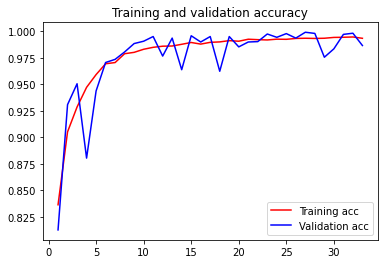

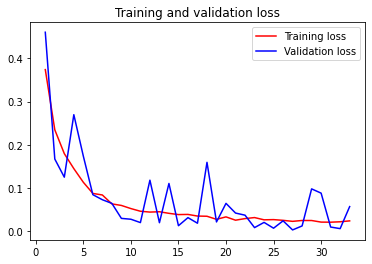

In [31]:
draw(history)

In [0]:
model_1.save(model_path + 'model1_15_8247.h5')

## Model 1 3 LSTM batch_size = 32 0.8309

In [0]:
def create_model_1():
  model = Sequential()
  model.add(Dense(units = 32, input_shape=(TIME_STEP, INPUT_DIM), activation='relu'))
  model.add(CuDNNLSTM(units = 32, input_shape=(TIME_STEP, INPUT_DIM), return_sequences = True))
  model.add(Dropout(DROPOUT))
  model.add(CuDNNLSTM(units = 32, input_shape=(TIME_STEP, INPUT_DIM), return_sequences = True))
  model.add(Dropout(DROPOUT))
  model.add(CuDNNLSTM(units = 32))
  model.add(Dense(1, activation='sigmoid'))
  model.summary()
  model.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['acc'])
  return model

In [33]:
# create model
model_1 = create_model_1()
history = model_1.fit(X_train, y_train, epochs=EPOCH, batch_size=32, 
                    validation_split=0.2, verbose=2, callbacks=callbacks_list)
score = model_1.evaluate(X_test, y_test, verbose=2)
print("test loss: ", score[0], "test acc: ", score[1])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 15, 32)            7200      
_________________________________________________________________
cu_dnnlstm_4 (CuDNNLSTM)     (None, 15, 32)            8448      
_________________________________________________________________
dropout_3 (Dropout)          (None, 15, 32)            0         
_________________________________________________________________
cu_dnnlstm_5 (CuDNNLSTM)     (None, 15, 32)            8448      
_________________________________________________________________
dropout_4 (Dropout)          (None, 15, 32)            0         
_________________________________________________________________
cu_dnnlstm_6 (CuDNNLSTM)     (None, 32)                8448      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

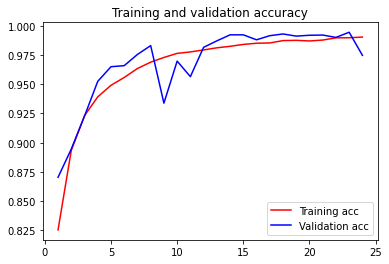

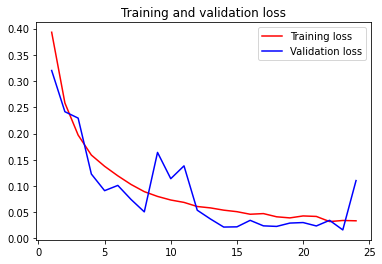

In [34]:
draw(history)

In [0]:
model_1.save(model_path + 'model1_15_8309.h5')

## Model 1 3 LSTM batch_size = 32 time_step = 20 0.8855

In [0]:
def create_model_1():
  model = Sequential()
  model.add(Dense(units = 32, input_shape=(TIME_STEP, INPUT_DIM), activation='relu'))
  model.add(CuDNNLSTM(units = 32, input_shape=(TIME_STEP, INPUT_DIM), return_sequences = True))
  model.add(Dropout(DROPOUT))
  model.add(CuDNNLSTM(units = 32, input_shape=(TIME_STEP, INPUT_DIM), return_sequences = True))
  model.add(Dropout(DROPOUT))
  model.add(CuDNNLSTM(units = 32))
  model.add(Dense(1, activation='sigmoid'))
  model.summary()
  model.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['acc'])
  return model

In [0]:
TIME_STEP = 20
y_train_20 = X_train_data['label'].to_numpy()[TIME_STEP - 1:]
y_test_20 = X_test_data['label'].to_numpy()[TIME_STEP - 1:]
X_train_20 = create_segments(X_train_data, TIME_STEP)
X_test_20 = create_segments(X_test_data, TIME_STEP)
# shuffle data
idx_train = np.random.permutation(y_train.shape[0])
X_train_20, y_train = X_train_20[idx_train], y_train[idx_train]

In [40]:
# create model
model_1 = create_model_1()
history = model_1.fit(X_train_20, y_train, epochs=EPOCH, batch_size=32, 
                    validation_split=0.2, verbose=2, callbacks=callbacks_list)
score = model_1.evaluate(X_test_20, y_test, verbose=2)
print("test loss: ", score[0], "test acc: ", score[1])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 20, 32)            7200      
_________________________________________________________________
cu_dnnlstm_10 (CuDNNLSTM)    (None, 20, 32)            8448      
_________________________________________________________________
dropout_7 (Dropout)          (None, 20, 32)            0         
_________________________________________________________________
cu_dnnlstm_11 (CuDNNLSTM)    (None, 20, 32)            8448      
_________________________________________________________________
dropout_8 (Dropout)          (None, 20, 32)            0         
_________________________________________________________________
cu_dnnlstm_12 (CuDNNLSTM)    (None, 32)                8448      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                

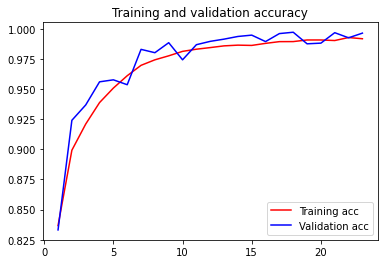

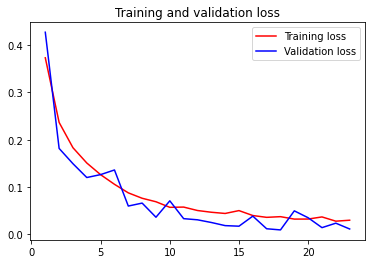

In [41]:
draw(history)

In [0]:
model_1.save(model_path + 'model1_20_8855.h5')

## Model 1 3 LSTM batch_size = 32 time_step = 20 opt 0.7498


In [0]:
def create_model_1():
  model = Sequential()
  model.add(Dense(units = 32, input_shape=(TIME_STEP, INPUT_DIM), activation='relu'))
  model.add(CuDNNLSTM(units = 32, input_shape=(TIME_STEP, INPUT_DIM), return_sequences = True))
  model.add(Dropout(DROPOUT))
  model.add(CuDNNLSTM(units = 32, input_shape=(TIME_STEP, INPUT_DIM), return_sequences = True))
  model.add(Dropout(DROPOUT))
  model.add(CuDNNLSTM(units = 32))
  model.add(Dense(1, activation='sigmoid'))
  model.summary()
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['acc'])
  return model

In [0]:
TIME_STEP = 20
y_train_20 = X_train_data['label'].to_numpy()[TIME_STEP - 1:]
y_test_20 = X_test_data['label'].to_numpy()[TIME_STEP - 1:]
X_train_20 = create_segments(X_train_data, TIME_STEP)
X_test_20 = create_segments(X_test_data, TIME_STEP)
# shuffle data
idx_train = np.random.permutation(y_train_20.shape[0])
X_train_20, y_train_20 = X_train_20[idx_train], y_train_20[idx_train]

In [158]:
# create model
model_1 = create_model_1()
history = model_1.fit(X_train_20, y_train_20, epochs=EPOCH, batch_size=32, 
                    validation_split=0.2, verbose=2, callbacks=callbacks_list)
score = model_1.evaluate(X_test_20, y_test_20, verbose=2)
print("test loss: ", score[0], "test acc: ", score[1])

Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_114 (Dense)            (None, 20, 32)            7200      
_________________________________________________________________
cu_dnnlstm_31 (CuDNNLSTM)    (None, 20, 32)            8448      
_________________________________________________________________
dropout_82 (Dropout)         (None, 20, 32)            0         
_________________________________________________________________
cu_dnnlstm_32 (CuDNNLSTM)    (None, 20, 32)            8448      
_________________________________________________________________
dropout_83 (Dropout)         (None, 20, 32)            0         
_________________________________________________________________
cu_dnnlstm_33 (CuDNNLSTM)    (None, 32)                8448      
_________________________________________________________________
dense_115 (Dense)            (None, 1)               

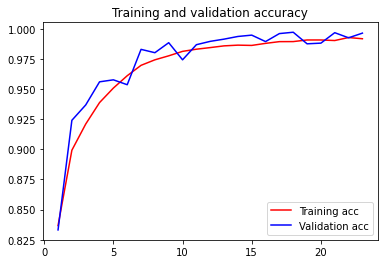

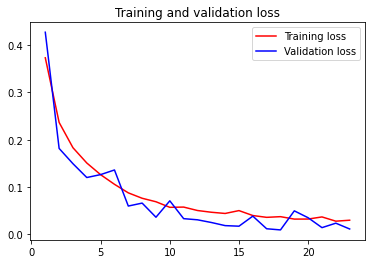

In [0]:
draw(history)

In [0]:
model_1.save(model_path + 'model1_20_7498.h5')

## Model 1 3 LSTM batch_size = 32 time_step = 30 0.7996

In [0]:
def create_model_1():
  model = Sequential()
  model.add(Dense(units = 32, input_shape=(TIME_STEP, INPUT_DIM), activation='relu'))
  model.add(CuDNNLSTM(units = 32, input_shape=(TIME_STEP, INPUT_DIM), return_sequences = True))
  model.add(Dropout(DROPOUT))
  model.add(CuDNNLSTM(units = 32, input_shape=(TIME_STEP, INPUT_DIM), return_sequences = True))
  model.add(Dropout(DROPOUT))
  model.add(CuDNNLSTM(units = 32))
  model.add(Dense(1, activation='sigmoid'))
  model.summary()
  model.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['acc'])
  return model

In [0]:
TIME_STEP = 30
y_train_30 = X_train_data['label'].to_numpy()[TIME_STEP - 1:]
y_test_30 = X_test_data['label'].to_numpy()[TIME_STEP - 1:]
X_train_30 = create_segments(X_train_data, TIME_STEP)
X_test_30 = create_segments(X_test_data, TIME_STEP)
# shuffle data
idx_train = np.random.permutation(y_train_30.shape[0])
X_train_30, y_train_30 = X_train_30[idx_train], y_train_30[idx_train]

In [136]:
# create model
model_1 = create_model_1()
history = model_1.fit(X_train_30, y_train_30, epochs=EPOCH, batch_size=32, 
                    validation_split=0.2, verbose=2, callbacks=callbacks_list)
score = model_1.evaluate(X_test_30, y_test_30, verbose=2)
print("test loss: ", score[0], "test acc: ", score[1])

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_102 (Dense)            (None, 30, 32)            7200      
_________________________________________________________________
cu_dnnlstm_13 (CuDNNLSTM)    (None, 30, 32)            8448      
_________________________________________________________________
dropout_70 (Dropout)         (None, 30, 32)            0         
_________________________________________________________________
cu_dnnlstm_14 (CuDNNLSTM)    (None, 30, 32)            8448      
_________________________________________________________________
dropout_71 (Dropout)         (None, 30, 32)            0         
_________________________________________________________________
cu_dnnlstm_15 (CuDNNLSTM)    (None, 32)                8448      
_________________________________________________________________
dense_103 (Dense)            (None, 1)               

In [0]:
model_1.save(model_path + 'model1_30_7996.h5')

## Model 1 3 LSTM batch_size = 32 time_step = 30 opt 0.8122

In [0]:
def create_model_1():
  model = Sequential()
  model.add(Dense(units = 32, input_shape=(TIME_STEP, INPUT_DIM), activation='relu'))
  model.add(CuDNNLSTM(units = 32, input_shape=(TIME_STEP, INPUT_DIM), return_sequences = True))
  model.add(Dropout(DROPOUT))
  model.add(CuDNNLSTM(units = 32, input_shape=(TIME_STEP, INPUT_DIM), return_sequences = True))
  model.add(Dropout(DROPOUT))
  model.add(CuDNNLSTM(units = 32))
  model.add(Dense(1, activation='sigmoid'))
  model.summary()
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['acc'])
  return model

In [0]:
TIME_STEP = 30
y_train_30 = X_train_data['label'].to_numpy()[TIME_STEP - 1:]
y_test_30 = X_test_data['label'].to_numpy()[TIME_STEP - 1:]
X_train_30 = create_segments(X_train_data, TIME_STEP)
X_test_30 = create_segments(X_test_data, TIME_STEP)
# shuffle data
idx_train = np.random.permutation(y_train_30.shape[0])
X_train_30, y_train_30 = X_train_30[idx_train], y_train_30[idx_train]

In [140]:
# create model
model_1 = create_model_1()
history = model_1.fit(X_train_30, y_train_30, epochs=EPOCH, batch_size=32, 
                    validation_split=0.2, verbose=2, callbacks=callbacks_list)
score = model_1.evaluate(X_test_30, y_test_30, verbose=2)
print("test loss: ", score[0], "test acc: ", score[1])

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_104 (Dense)            (None, 30, 32)            7200      
_________________________________________________________________
cu_dnnlstm_16 (CuDNNLSTM)    (None, 30, 32)            8448      
_________________________________________________________________
dropout_72 (Dropout)         (None, 30, 32)            0         
_________________________________________________________________
cu_dnnlstm_17 (CuDNNLSTM)    (None, 30, 32)            8448      
_________________________________________________________________
dropout_73 (Dropout)         (None, 30, 32)            0         
_________________________________________________________________
cu_dnnlstm_18 (CuDNNLSTM)    (None, 32)                8448      
_________________________________________________________________
dense_105 (Dense)            (None, 1)               

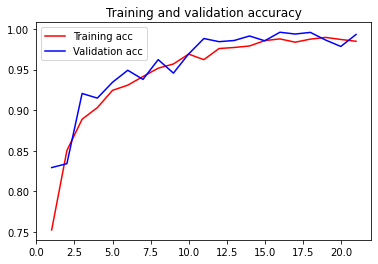

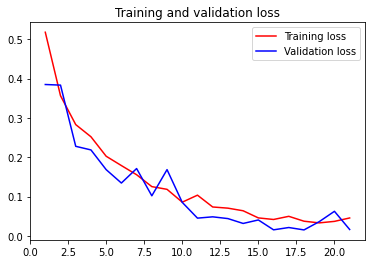

In [141]:
draw(history)

In [0]:
model_1.save(model_path + 'model1_30_8122.h5')

## Model 1 3 LSTM batch_size = 32 time_step = 30 opt unit=64 0.8210

In [0]:
def create_model_1():
  model = Sequential()
  model.add(Dense(units = 64, input_shape=(TIME_STEP, INPUT_DIM), activation='relu'))
  model.add(CuDNNLSTM(units = 64, input_shape=(TIME_STEP, INPUT_DIM), return_sequences = True))
  model.add(Dropout(DROPOUT))
  model.add(CuDNNLSTM(units = 32, input_shape=(TIME_STEP, INPUT_DIM), return_sequences = True))
  model.add(Dropout(DROPOUT))
  model.add(CuDNNLSTM(units = 32))
  model.add(Dense(1, activation='sigmoid'))
  model.summary()
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['acc'])
  return model

In [144]:
# create model
model_1 = create_model_1()
history = model_1.fit(X_train_30, y_train_30, epochs=EPOCH, batch_size=32, 
                    validation_split=0.2, verbose=2, callbacks=callbacks_list)
score = model_1.evaluate(X_test_30, y_test_30, verbose=2)
print("test loss: ", score[0], "test acc: ", score[1])

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_106 (Dense)            (None, 30, 64)            14400     
_________________________________________________________________
cu_dnnlstm_19 (CuDNNLSTM)    (None, 30, 64)            33280     
_________________________________________________________________
dropout_74 (Dropout)         (None, 30, 64)            0         
_________________________________________________________________
cu_dnnlstm_20 (CuDNNLSTM)    (None, 30, 32)            12544     
_________________________________________________________________
dropout_75 (Dropout)         (None, 30, 32)            0         
_________________________________________________________________
cu_dnnlstm_21 (CuDNNLSTM)    (None, 32)                8448      
_________________________________________________________________
dense_107 (Dense)            (None, 1)               

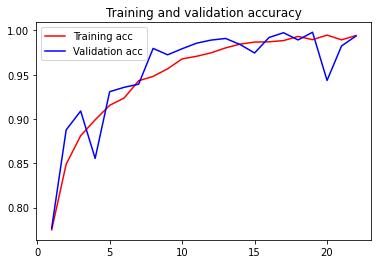

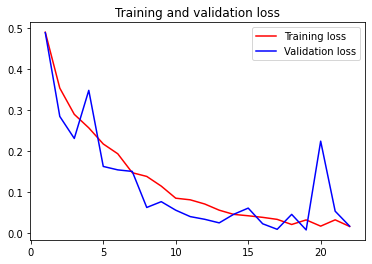

In [145]:
draw(history)

In [0]:
model_1.save(model_path + 'model1_30_8210.h5')

## Model 1 3 LSTM batch_size = 64 time_step = 30 opt unit=64 0.7431

In [0]:
def create_model_1():
  model = Sequential()
  model.add(Dense(units = 64, input_shape=(TIME_STEP, INPUT_DIM), activation='relu'))
  model.add(CuDNNLSTM(units = 64, input_shape=(TIME_STEP, INPUT_DIM), return_sequences = True))
  model.add(Dropout(DROPOUT))
  model.add(CuDNNLSTM(units = 32, input_shape=(TIME_STEP, INPUT_DIM), return_sequences = True))
  model.add(Dropout(DROPOUT))
  model.add(CuDNNLSTM(units = 32))
  model.add(Dense(1, activation='sigmoid'))
  model.summary()
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['acc'])
  return model

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_108 (Dense)            (None, 30, 64)            14400     
_________________________________________________________________
cu_dnnlstm_22 (CuDNNLSTM)    (None, 30, 64)            33280     
_________________________________________________________________
dropout_76 (Dropout)         (None, 30, 64)            0         
_________________________________________________________________
cu_dnnlstm_23 (CuDNNLSTM)    (None, 30, 32)            12544     
_________________________________________________________________
dropout_77 (Dropout)         (None, 30, 32)            0         
_________________________________________________________________
cu_dnnlstm_24 (CuDNNLSTM)    (None, 32)                8448      
_________________________________________________________________
dense_109 (Dense)            (None, 1)               

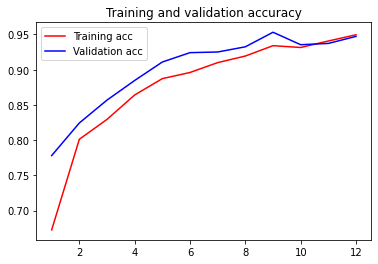

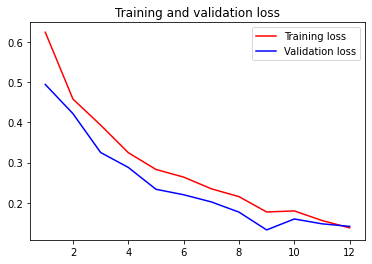

In [148]:
# create model
model_1 = create_model_1()
history = model_1.fit(X_train_30, y_train_30, epochs=EPOCH, batch_size=64, 
                    validation_split=0.2, verbose=2, callbacks=callbacks_list)
score = model_1.evaluate(X_test_30, y_test_30, verbose=2)
print("test loss: ", score[0], "test acc: ", score[1])
draw(history)

## Model 1 3 LSTM batch_size = 32 time_step = 30 opt unit=64 split=0.15 0.8589

In [0]:
def create_model_1():
  model = Sequential()
  model.add(Dense(units = 64, input_shape=(TIME_STEP, INPUT_DIM), activation='relu'))
  model.add(CuDNNLSTM(units = 64, input_shape=(TIME_STEP, INPUT_DIM), return_sequences = True))
  model.add(Dropout(DROPOUT))
  model.add(CuDNNLSTM(units = 32, input_shape=(TIME_STEP, INPUT_DIM), return_sequences = True))
  model.add(Dropout(DROPOUT))
  model.add(CuDNNLSTM(units = 32))
  model.add(Dense(1, activation='sigmoid'))
  model.summary()
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['acc'])
  return model

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_110 (Dense)            (None, 30, 64)            14400     
_________________________________________________________________
cu_dnnlstm_25 (CuDNNLSTM)    (None, 30, 64)            33280     
_________________________________________________________________
dropout_78 (Dropout)         (None, 30, 64)            0         
_________________________________________________________________
cu_dnnlstm_26 (CuDNNLSTM)    (None, 30, 32)            12544     
_________________________________________________________________
dropout_79 (Dropout)         (None, 30, 32)            0         
_________________________________________________________________
cu_dnnlstm_27 (CuDNNLSTM)    (None, 32)                8448      
_________________________________________________________________
dense_111 (Dense)            (None, 1)               

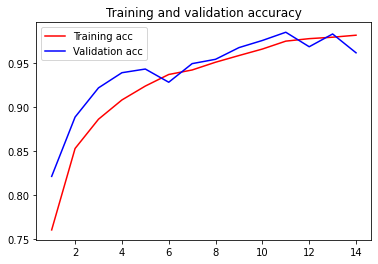

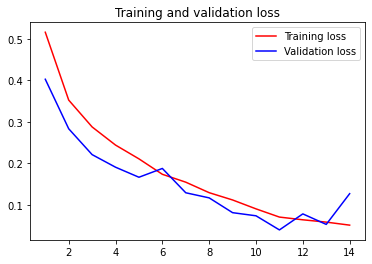

In [150]:
# create model
model_1 = create_model_1()
history = model_1.fit(X_train_30, y_train_30, epochs=EPOCH, batch_size=32, 
                    validation_split=0.15, verbose=2, callbacks=callbacks_list)
score = model_1.evaluate(X_test_30, y_test_30, verbose=2)
print("test loss: ", score[0], "test acc: ", score[1])
draw(history)

In [0]:
model_1.save(model_path + 'model1_30_8589.h5')

## Model 2 CNN Batch_size = 32 0.8364

In [0]:
def create_model_2(X_train):
  model = Sequential()

  model.add(Conv1D(32, 3, padding ='same', input_shape=(X_train.shape[1:])))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Conv1D(32, 3, padding ='same'))
  # model.add(BatchNormalization())
  
  model.add(Conv1D(32, 3, padding ='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Conv1D(32, 3, padding ='same'))
  # model.add(BatchNormalization())

  model.add(GlobalAveragePooling1D())
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.5))
  
  model.add(Dense(64, activation = 'relu'))
  model.add(Dropout(0.5))
  model.add(Dense(1, activation='sigmoid'))
  model.summary()
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['acc'])
  return model

In [71]:
# create model
model_1 = create_model_2(X_train)
history = model_1.fit(X_train, y_train, epochs=EPOCH, batch_size=32, 
                    validation_split=0.2, verbose=2, callbacks=callbacks_list)
score = model_1.evaluate(X_test, y_test, verbose=2)
print("test loss: ", score[0], "test acc: ", score[1])

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_51 (Conv1D)           (None, 15, 32)            21536     
_________________________________________________________________
batch_normalization_37 (Batc (None, 15, 32)            128       
_________________________________________________________________
activation_26 (Activation)   (None, 15, 32)            0         
_________________________________________________________________
conv1d_52 (Conv1D)           (None, 15, 32)            3104      
_________________________________________________________________
conv1d_53 (Conv1D)           (None, 15, 32)            3104      
_________________________________________________________________
batch_normalization_38 (Batc (None, 15, 32)            128       
_________________________________________________________________
activation_27 (Activation)   (None, 15, 32)          

In [0]:
model_1.save(model_path + 'model2_15_8364.h5')

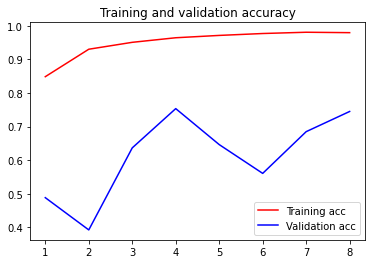

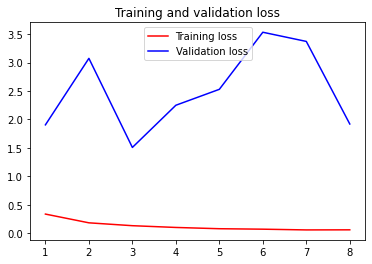

In [72]:
draw(history)

## Model 2 CNN batch_size = 64 0.7592

In [75]:
# create model
model_2 = create_model_2(X_train)
history = model_2.fit(X_train, y_train, epochs=EPOCH, batch_size=64, 
                    validation_split=0.2, verbose=2, callbacks=callbacks_list)
score = model_2.evaluate(X_test, y_test, verbose=2)
print("test loss: ", score[0], "test acc: ", score[1])

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_55 (Conv1D)           (None, 15, 32)            21536     
_________________________________________________________________
batch_normalization_39 (Batc (None, 15, 32)            128       
_________________________________________________________________
activation_28 (Activation)   (None, 15, 32)            0         
_________________________________________________________________
conv1d_56 (Conv1D)           (None, 15, 32)            3104      
_________________________________________________________________
conv1d_57 (Conv1D)           (None, 15, 32)            3104      
_________________________________________________________________
batch_normalization_40 (Batc (None, 15, 32)            128       
_________________________________________________________________
activation_29 (Activation)   (None, 15, 32)          

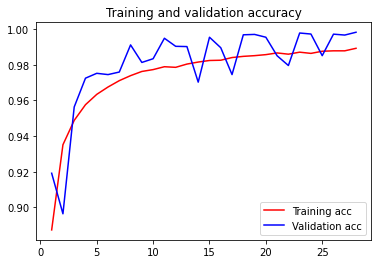

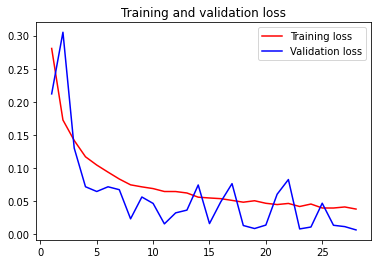

In [0]:
draw(history)

In [0]:
model_1.save(model_path + 'model1_8372.csv')

## Model 2 CNN batch_size = 16 0.7501

In [76]:
# create model
model_2 = create_model_2(X_train)
history = model_2.fit(X_train, y_train, epochs=EPOCH, batch_size=16, 
                    validation_split=0.2, verbose=2, callbacks=callbacks_list)
score = model_2.evaluate(X_test, y_test, verbose=2)
print("test loss: ", score[0], "test acc: ", score[1])

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_59 (Conv1D)           (None, 15, 32)            21536     
_________________________________________________________________
batch_normalization_41 (Batc (None, 15, 32)            128       
_________________________________________________________________
activation_30 (Activation)   (None, 15, 32)            0         
_________________________________________________________________
conv1d_60 (Conv1D)           (None, 15, 32)            3104      
_________________________________________________________________
conv1d_61 (Conv1D)           (None, 15, 32)            3104      
_________________________________________________________________
batch_normalization_42 (Batc (None, 15, 32)            128       
_________________________________________________________________
activation_31 (Activation)   (None, 15, 32)          

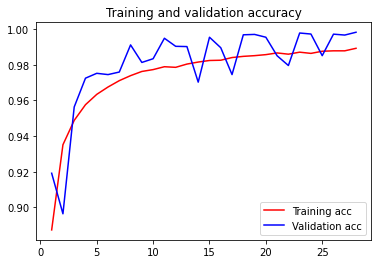

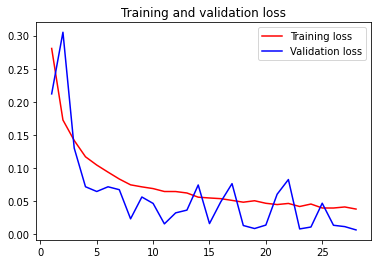

In [0]:
draw(history)

In [0]:
model_1.save(model_path + 'model1_8372.csv')

## Model 2 CNN val_split = 0.15 0.7576

In [77]:
# create model
model_2 = create_model_2(X_train)
history = model_2.fit(X_train, y_train, epochs=EPOCH, batch_size=32, 
                    validation_split=0.15, verbose=2, callbacks=callbacks_list)
score = model_2.evaluate(X_test, y_test, verbose=2)
print("test loss: ", score[0], "test acc: ", score[1])

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_63 (Conv1D)           (None, 15, 32)            21536     
_________________________________________________________________
batch_normalization_43 (Batc (None, 15, 32)            128       
_________________________________________________________________
activation_32 (Activation)   (None, 15, 32)            0         
_________________________________________________________________
conv1d_64 (Conv1D)           (None, 15, 32)            3104      
_________________________________________________________________
conv1d_65 (Conv1D)           (None, 15, 32)            3104      
_________________________________________________________________
batch_normalization_44 (Batc (None, 15, 32)            128       
_________________________________________________________________
activation_33 (Activation)   (None, 15, 32)          

In [0]:
model_1.save(model_path + 'model1_8286.csv')

## Model 2 CNN time_step = 20 0.7169

In [0]:
TIME_STEP = 20
y_train_20 = X_train_data['label'].to_numpy()[TIME_STEP - 1:]
y_test_20 = X_test_data['label'].to_numpy()[TIME_STEP - 1:]
X_train_20 = create_segments(X_train_data, TIME_STEP)
X_test_20 = create_segments(X_test_data, TIME_STEP)
# shuffle data
idx_train = np.random.permutation(y_train_20.shape[0])
X_train_20, y_train_20 = X_train_20[idx_train], y_train_20[idx_train]

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_71 (Conv1D)           (None, 20, 32)            21536     
_________________________________________________________________
batch_normalization_47 (Batc (None, 20, 32)            128       
_________________________________________________________________
activation_36 (Activation)   (None, 20, 32)            0         
_________________________________________________________________
conv1d_72 (Conv1D)           (None, 20, 32)            3104      
_________________________________________________________________
conv1d_73 (Conv1D)           (None, 20, 32)            3104      
_________________________________________________________________
batch_normalization_48 (Batc (None, 20, 32)            128       
_________________________________________________________________
activation_37 (Activation)   (None, 20, 32)          

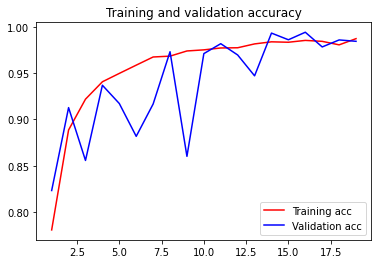

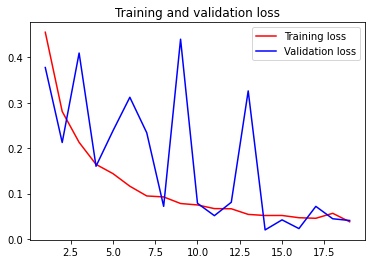

In [82]:
# create model
model_2_20 = create_model_2(X_train_20)
history = model_2_20.fit(X_train_20, y_train_20, epochs=EPOCH, batch_size=32, 
                    validation_split=0.2, verbose=2, callbacks=callbacks_list)
score = model_2_20.evaluate(X_test_20, y_test_20, verbose=2)
print("test loss: ", score[0], "test acc: ", score[1])
draw(history)

In [0]:
model_2_20.save(model_path + 'model2_20_8168.h5')

## Model 2 CNN time_step = 30 0.8235


In [0]:
TIME_STEP = 30
y_train_30 = X_train_data['label'].to_numpy()[TIME_STEP - 1:]
y_test_30 = X_test_data['label'].to_numpy()[TIME_STEP - 1:]
X_train_30 = create_segments(X_train_data, TIME_STEP)
X_test_30 = create_segments(X_test_data, TIME_STEP)
# shuffle data
idx_train = np.random.permutation(y_train_30.shape[0])
X_train_30, y_train_30 = X_train_30[idx_train], y_train_30[idx_train]

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_79 (Conv1D)           (None, 30, 32)            21536     
_________________________________________________________________
batch_normalization_51 (Batc (None, 30, 32)            128       
_________________________________________________________________
activation_40 (Activation)   (None, 30, 32)            0         
_________________________________________________________________
conv1d_80 (Conv1D)           (None, 30, 32)            3104      
_________________________________________________________________
conv1d_81 (Conv1D)           (None, 30, 32)            3104      
_________________________________________________________________
batch_normalization_52 (Batc (None, 30, 32)            128       
_________________________________________________________________
activation_41 (Activation)   (None, 30, 32)          

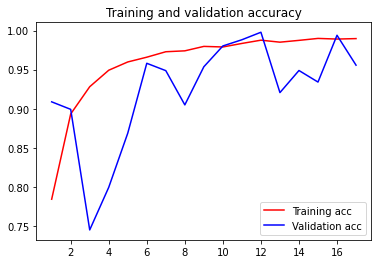

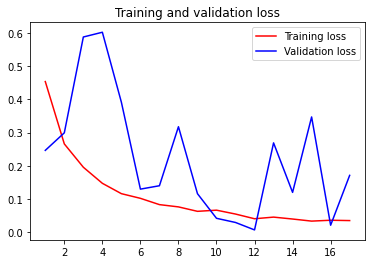

In [85]:
# create model
model_2_30 = create_model_2(X_train_30)
history = model_2_30.fit(X_train_30, y_train_30, epochs=EPOCH, batch_size=32, 
                    validation_split=0.2, verbose=2, callbacks=callbacks_list)
score = model_2_30.evaluate(X_test_30, y_test_30, verbose=2)
print("test loss: ", score[0], "test acc: ", score[1])
draw(history)

##Model 2 CNN time = 30, split = 0.15 0.8350

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_83 (Conv1D)           (None, 30, 32)            21536     
_________________________________________________________________
batch_normalization_53 (Batc (None, 30, 32)            128       
_________________________________________________________________
activation_42 (Activation)   (None, 30, 32)            0         
_________________________________________________________________
conv1d_84 (Conv1D)           (None, 30, 32)            3104      
_________________________________________________________________
conv1d_85 (Conv1D)           (None, 30, 32)            3104      
_________________________________________________________________
batch_normalization_54 (Batc (None, 30, 32)            128       
_________________________________________________________________
activation_43 (Activation)   (None, 30, 32)          

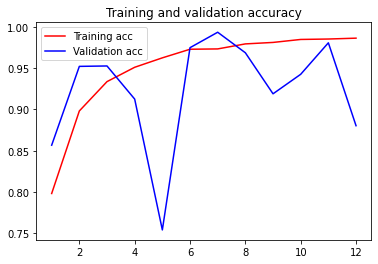

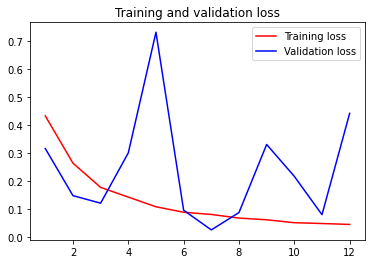

In [87]:
# create model
model_2_30 = create_model_2(X_train_30)
history = model_2_30.fit(X_train_30, y_train_30, epochs=EPOCH, batch_size=32, 
                    validation_split=0.15, verbose=2, callbacks=callbacks_list)
score = model_2_30.evaluate(X_test_30, y_test_30, verbose=2)
print("test loss: ", score[0], "test acc: ", score[1])
draw(history)

In [0]:
model_2_30.save(model_path + 'model2_30_8350.h5')

##Model 2 CNN time = 30, split = 0.15 dropout 0.4 0.2 0.8764

In [0]:
def create_model_2(X_train):
  model = Sequential()

  model.add(Conv1D(32, 3, padding ='same', input_shape=(X_train.shape[1:])))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Conv1D(32, 3, padding ='same'))
  # model.add(BatchNormalization())
  
  model.add(Conv1D(32, 3, padding ='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Conv1D(32, 3, padding ='same'))
  # model.add(BatchNormalization())

  model.add(GlobalAveragePooling1D())
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.4))
  
  model.add(Dense(64, activation = 'relu'))
  model.add(Dropout(0.2))
  model.add(Dense(1, activation='sigmoid'))
  model.summary()
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['acc'])
  return model

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_87 (Conv1D)           (None, 30, 32)            21536     
_________________________________________________________________
batch_normalization_55 (Batc (None, 30, 32)            128       
_________________________________________________________________
activation_44 (Activation)   (None, 30, 32)            0         
_________________________________________________________________
conv1d_88 (Conv1D)           (None, 30, 32)            3104      
_________________________________________________________________
conv1d_89 (Conv1D)           (None, 30, 32)            3104      
_________________________________________________________________
batch_normalization_56 (Batc (None, 30, 32)            128       
_________________________________________________________________
activation_45 (Activation)   (None, 30, 32)          

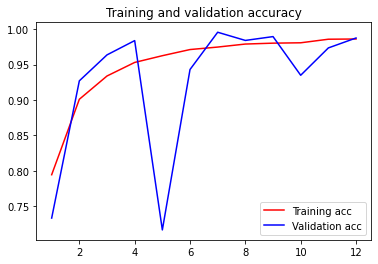

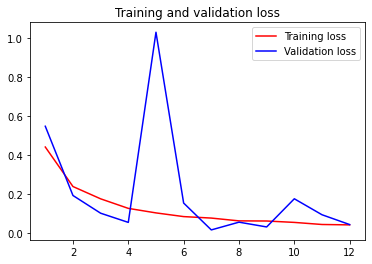

In [94]:
# create model
model_2_30 = create_model_2(X_train_30)
history = model_2_30.fit(X_train_30, y_train_30, epochs=EPOCH, batch_size=32, 
                    validation_split=0.15, verbose=2, callbacks=callbacks_list)
score = model_2_30.evaluate(X_test_30, y_test_30, verbose=2)
print("test loss: ", score[0], "test acc: ", score[1])
draw(history)

In [0]:
model_2_30.save(model_path + 'model2_30_8764.h5')

##Model 2 CNN time = 30, split = 0.15 dropout 0.5 0.2 0.8813

In [0]:
def create_model_2(X_train):
  model = Sequential()

  model.add(Conv1D(32, 3, padding ='same', input_shape=(X_train.shape[1:])))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Conv1D(32, 3, padding ='same'))
  # model.add(BatchNormalization())
  
  model.add(Conv1D(32, 3, padding ='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Conv1D(32, 3, padding ='same'))
  # model.add(BatchNormalization())

  model.add(GlobalAveragePooling1D())
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.5))
  
  model.add(Dense(64, activation = 'relu'))
  model.add(Dropout(0.2))
  model.add(Dense(1, activation='sigmoid'))
  model.summary()
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['acc'])
  return model

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_91 (Conv1D)           (None, 30, 32)            21536     
_________________________________________________________________
batch_normalization_57 (Batc (None, 30, 32)            128       
_________________________________________________________________
activation_46 (Activation)   (None, 30, 32)            0         
_________________________________________________________________
conv1d_92 (Conv1D)           (None, 30, 32)            3104      
_________________________________________________________________
conv1d_93 (Conv1D)           (None, 30, 32)            3104      
_________________________________________________________________
batch_normalization_58 (Batc (None, 30, 32)            128       
_________________________________________________________________
activation_47 (Activation)   (None, 30, 32)          

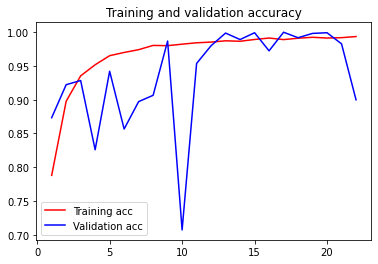

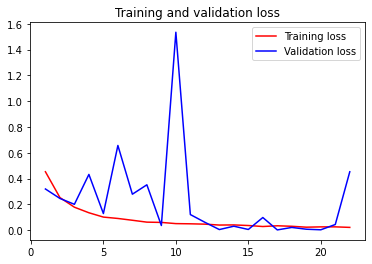

In [98]:
model_2_30 = create_model_2(X_train_30)
history = model_2_30.fit(X_train_30, y_train_30, epochs=EPOCH, batch_size=32, 
                    validation_split=0.15, verbose=2, callbacks=callbacks_list)
score = model_2_30.evaluate(X_test_30, y_test_30, verbose=2)
print("test loss: ", score[0], "test acc: ", score[1])
draw(history)

In [0]:
model_2_30.save(model_path + 'model2_30_8813.h5')

##Model 2 CNN time = 30, split = 0.15 dropout 0.6 0.2 0.8786

In [0]:
def create_model_2(X_train):
  model = Sequential()

  model.add(Conv1D(32, 3, padding ='same', input_shape=(X_train.shape[1:])))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Conv1D(32, 3, padding ='same'))
  # model.add(BatchNormalization())
  
  model.add(Conv1D(32, 3, padding ='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Conv1D(32, 3, padding ='same'))
  # model.add(BatchNormalization())

  model.add(GlobalAveragePooling1D())
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.6))
  
  model.add(Dense(64, activation = 'relu'))
  model.add(Dropout(0.2))
  model.add(Dense(1, activation='sigmoid'))
  model.summary()
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['acc'])
  return model

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_99 (Conv1D)           (None, 30, 32)            21536     
_________________________________________________________________
batch_normalization_61 (Batc (None, 30, 32)            128       
_________________________________________________________________
activation_50 (Activation)   (None, 30, 32)            0         
_________________________________________________________________
conv1d_100 (Conv1D)          (None, 30, 32)            3104      
_________________________________________________________________
conv1d_101 (Conv1D)          (None, 30, 32)            3104      
_________________________________________________________________
batch_normalization_62 (Batc (None, 30, 32)            128       
_________________________________________________________________
activation_51 (Activation)   (None, 30, 32)          

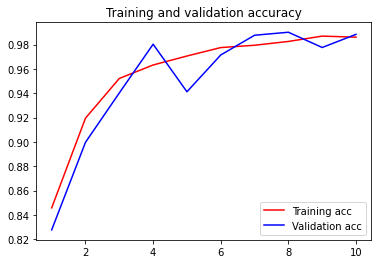

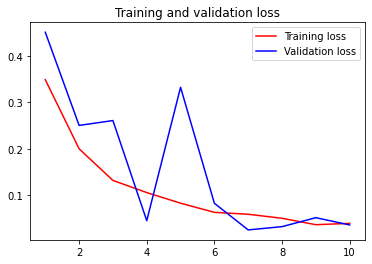

In [105]:
model_2_30 = create_model_2(X_train_30)
history = model_2_30.fit(X_train_30, y_train_30, epochs=EPOCH, batch_size=32, 
                    validation_split=0.15, verbose=2, callbacks=callbacks_list)
score = model_2_30.evaluate(X_test_30, y_test_30, verbose=2)
print("test loss: ", score[0], "test acc: ", score[1])
draw(history)

In [0]:
model_2_30.save(model_path + 'model2_30_8797.h5')

##Model 2 CNN time = 30, split = 0.15 dropout 0.5 0.3 0.8228

In [0]:
def create_model_2(X_train):
  model = Sequential()

  model.add(Conv1D(32, 3, padding ='same', input_shape=(X_train.shape[1:])))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Conv1D(32, 3, padding ='same'))
  # model.add(BatchNormalization())
  
  model.add(Conv1D(32, 3, padding ='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Conv1D(32, 3, padding ='same'))
  # model.add(BatchNormalization())

  model.add(GlobalAveragePooling1D())
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.5))
  
  model.add(Dense(64, activation = 'relu'))
  model.add(Dropout(0.3))
  model.add(Dense(1, activation='sigmoid'))
  model.summary()
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['acc'])
  return model

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_103 (Conv1D)          (None, 30, 32)            21536     
_________________________________________________________________
batch_normalization_63 (Batc (None, 30, 32)            128       
_________________________________________________________________
activation_52 (Activation)   (None, 30, 32)            0         
_________________________________________________________________
conv1d_104 (Conv1D)          (None, 30, 32)            3104      
_________________________________________________________________
conv1d_105 (Conv1D)          (None, 30, 32)            3104      
_________________________________________________________________
batch_normalization_64 (Batc (None, 30, 32)            128       
_________________________________________________________________
activation_53 (Activation)   (None, 30, 32)          

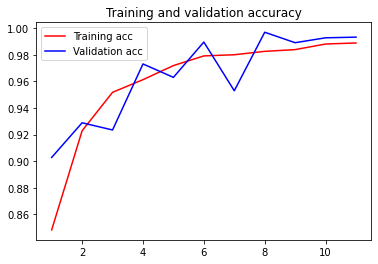

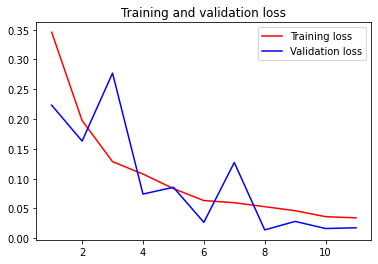

In [108]:
model_2_30 = create_model_2(X_train_30)
history = model_2_30.fit(X_train_30, y_train_30, epochs=EPOCH, batch_size=32, 
                    validation_split=0.15, verbose=2, callbacks=callbacks_list)
score = model_2_30.evaluate(X_test_30, y_test_30, verbose=2)
print("test loss: ", score[0], "test acc: ", score[1])
draw(history)

In [0]:
model_2_30.save(model_path + 'model2_30_8228.h5')

##Model 2 CNN time = 30, split = 0.15 dropout 0.5 0.1 0.8571

In [0]:
def create_model_2(X_train):
  model = Sequential()

  model.add(Conv1D(32, 3, padding ='same', input_shape=(X_train.shape[1:])))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Conv1D(32, 3, padding ='same'))
  # model.add(BatchNormalization())
  
  model.add(Conv1D(32, 3, padding ='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Conv1D(32, 3, padding ='same'))
  # model.add(BatchNormalization())

  model.add(GlobalAveragePooling1D())
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.5))
  
  model.add(Dense(64, activation = 'relu'))
  model.add(Dropout(0.1))
  model.add(Dense(1, activation='sigmoid'))
  model.summary()
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['acc'])
  return model

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_107 (Conv1D)          (None, 30, 32)            21536     
_________________________________________________________________
batch_normalization_65 (Batc (None, 30, 32)            128       
_________________________________________________________________
activation_54 (Activation)   (None, 30, 32)            0         
_________________________________________________________________
conv1d_108 (Conv1D)          (None, 30, 32)            3104      
_________________________________________________________________
conv1d_109 (Conv1D)          (None, 30, 32)            3104      
_________________________________________________________________
batch_normalization_66 (Batc (None, 30, 32)            128       
_________________________________________________________________
activation_55 (Activation)   (None, 30, 32)          

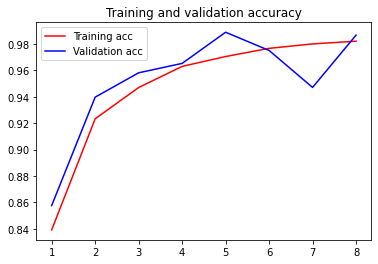

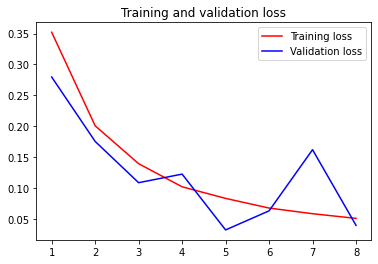

In [111]:
model_2_30 = create_model_2(X_train_30)
history = model_2_30.fit(X_train_30, y_train_30, epochs=EPOCH, batch_size=32, 
                    validation_split=0.15, verbose=2, callbacks=callbacks_list)
score = model_2_30.evaluate(X_test_30, y_test_30, verbose=2)
print("test loss: ", score[0], "test acc: ", score[1])
draw(history)

In [0]:
model_2_30.save(model_path + 'model2_30_8571.h5')

##Model 2 CNN time = 30, split = 0.15 dropout 0.5 0.2 0.8689

In [0]:
def create_model_2(X_train):
  model = Sequential()

  model.add(Conv1D(32, 3, padding ='same', input_shape=(X_train.shape[1:])))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Conv1D(32, 3, padding ='same'))
  # model.add(BatchNormalization())
  
  model.add(Conv1D(32, 3, padding ='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Conv1D(32, 3, padding ='same'))
  # model.add(BatchNormalization())

  model.add(GlobalAveragePooling1D())
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.5))
  
  model.add(Dense(64, activation = 'relu'))
  model.add(Dropout(0.2))
  model.add(Dense(1, activation='sigmoid'))
  model.summary()
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['acc'])
  return model

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_127 (Conv1D)          (None, 30, 32)            21536     
_________________________________________________________________
batch_normalization_75 (Batc (None, 30, 32)            128       
_________________________________________________________________
activation_64 (Activation)   (None, 30, 32)            0         
_________________________________________________________________
conv1d_128 (Conv1D)          (None, 30, 32)            3104      
_________________________________________________________________
conv1d_129 (Conv1D)          (None, 30, 32)            3104      
_________________________________________________________________
batch_normalization_76 (Batc (None, 30, 32)            128       
_________________________________________________________________
activation_65 (Activation)   (None, 30, 32)          

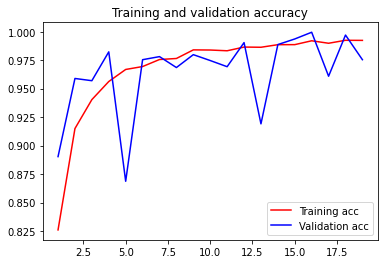

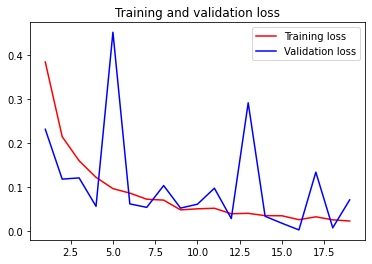

In [126]:
model_2_30 = create_model_2(X_train_30)
history = model_2_30.fit(X_train_30, y_train_30, epochs=EPOCH, batch_size=32, 
                    validation_split=0.15, verbose=2, callbacks=callbacks_list)
score = model_2_30.evaluate(X_test_30, y_test_30, verbose=2)
print("test loss: ", score[0], "test acc: ", score[1])
draw(history)

In [0]:
model_2_30.save(model_path + 'model2_30_8689.h5')

##Model 2 CNN time = 30, split = 0.15 dropout 0.5 0.2 0.7916

In [0]:
def create_model_2(X_train):
  model = Sequential()

  model.add(Conv1D(32, 3, padding ='same', input_shape=(X_train.shape[1:])))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Conv1D(32, 3, padding ='same'))
  # model.add(BatchNormalization())
  
  model.add(Conv1D(32, 3, padding ='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Conv1D(32, 3, padding ='same'))
  # model.add(BatchNormalization())

  model.add(GlobalMaxPooling1D())
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.5))
  
  model.add(Dense(64, activation = 'relu'))
  model.add(Dropout(0.2))
  model.add(Dense(1, activation='sigmoid'))
  model.summary()
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['acc'])
  return model

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_131 (Conv1D)          (None, 30, 32)            21536     
_________________________________________________________________
batch_normalization_77 (Batc (None, 30, 32)            128       
_________________________________________________________________
activation_66 (Activation)   (None, 30, 32)            0         
_________________________________________________________________
conv1d_132 (Conv1D)          (None, 30, 32)            3104      
_________________________________________________________________
conv1d_133 (Conv1D)          (None, 30, 32)            3104      
_________________________________________________________________
batch_normalization_78 (Batc (None, 30, 32)            128       
_________________________________________________________________
activation_67 (Activation)   (None, 30, 32)          

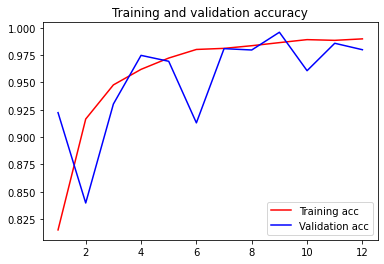

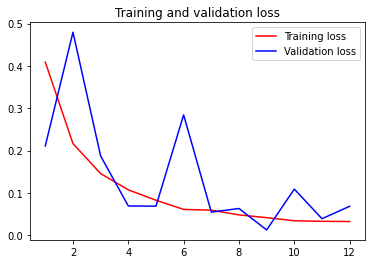

In [131]:
model_2_30 = create_model_2(X_train_30)
history = model_2_30.fit(X_train_30, y_train_30, epochs=EPOCH, batch_size=32, 
                    validation_split=0.15, verbose=2, callbacks=callbacks_list)
score = model_2_30.evaluate(X_test_30, y_test_30, verbose=2)
print("test loss: ", score[0], "test acc: ", score[1])
draw(history)

In [0]:
model_2_30.save(model_path + 'model2_30_7916.h5')